## Data Prep

In [36]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [37]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [38]:
# follow same data prep procedures from ARIMA
data_clean = pd.read_csv('data_clean.csv')
data_clean = data_clean[['date', 'new_cases','location']]
data_clean['date'] = pd.to_datetime(data_clean['date'])
#rename for prophet
data_clean.rename(columns={'date': 'ds', 'new_cases': 'y'}, inplace=True)
data_clean['ds'] = pd.to_datetime(data_clean['ds'])
data_clean.describe()

,ds,y
count,10300,10300.000000
mean,2021-08-17 12:00:00.000000256,7217.275922
min,2020-03-21 00:00:00,0.000000
25%,2020-12-03 00:00:00,349.000000
50%,2021-08-17 12:00:00,1194.500000
75%,2022-05-02 00:00:00,5130.500000
max,2023-01-14 00:00:00,275647.000000
std,NaN,18098.866379


In [39]:
# account for lockdowns
from prophet.make_holidays import make_holidays_df
# Belgium 
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days
belgium_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Belgium')
holiday_belgium = pd.concat((belgium_lockdowns, belgium_holidays))
holiday_belgium = holiday_belgium.reset_index(drop=True)
holiday_belgium.loc[2:, 'ds_upper'] = holiday_belgium.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Denmark 
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days
denmark_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Denmark')
holiday_denmark = pd.concat((denmark_lockdowns, denmark_holidays))
holiday_denmark = holiday_denmark.reset_index(drop=True)
holiday_denmark.loc[2:, 'ds_upper'] = holiday_denmark.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days
finland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Finland')
holiday_finland = pd.concat((finland_lockdowns, finland_holidays))
holiday_finland = holiday_finland.reset_index(drop=True)
holiday_finland.loc[2:, 'ds_upper'] = holiday_finland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days
ireland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Ireland')
holiday_ireland = pd.concat((ireland_lockdowns, ireland_holidays))
holiday_ireland = holiday_ireland.reset_index(drop=True)
holiday_ireland.loc[2:, 'ds_upper'] = holiday_ireland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days
italy_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Italy')
holiday_italy = pd.concat((italy_lockdowns, italy_holidays))
holiday_italy = holiday_italy.reset_index(drop=True)
holiday_italy.loc[2:, 'ds_upper'] = holiday_italy.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days
lithuania_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Lithuania')
holiday_lithuania = pd.concat((lithuania_lockdowns, lithuania_holidays))
holiday_lithuania = holiday_lithuania.reset_index(drop=True)
holiday_lithuania.loc[2:, 'ds_upper'] = holiday_lithuania.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days
norway_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Norway')
holiday_norway = pd.concat((norway_lockdowns, norway_holidays))
holiday_norway = holiday_norway.reset_index(drop=True)
holiday_norway.loc[2:, 'ds_upper'] = holiday_norway.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days
poland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Poland')
holiday_poland = pd.concat((poland_lockdowns, poland_holidays))
holiday_poland = holiday_poland.reset_index(drop=True)
holiday_poland.loc[2:, 'ds_upper'] = holiday_poland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days
switzerland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Switzerland')
holiday_switzerland = pd.concat((swiss_lockdowns, switzerland_holidays))
holiday_switzerland = holiday_switzerland.reset_index(drop=True)
holiday_switzerland.loc[2:, 'ds_upper'] = holiday_switzerland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days
uk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='UK')
holiday_unitedkingdom = pd.concat((uk_lockdowns, uk_holidays))
holiday_unitedkingdom = holiday_unitedkingdom.reset_index(drop=True)
holiday_unitedkingdom.loc[2:, 'ds_upper'] = holiday_unitedkingdom.loc[2:, 'ds'] + pd.Timedelta(days=7)

In [40]:
data_italy = data_clean[data_clean['location'] == 'Italy']
data_italy = data_italy.drop(['location'], axis=1)
train_italy=data_italy.iloc[:-14 ]
test_italy=data_italy.iloc[-14: ]

13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing


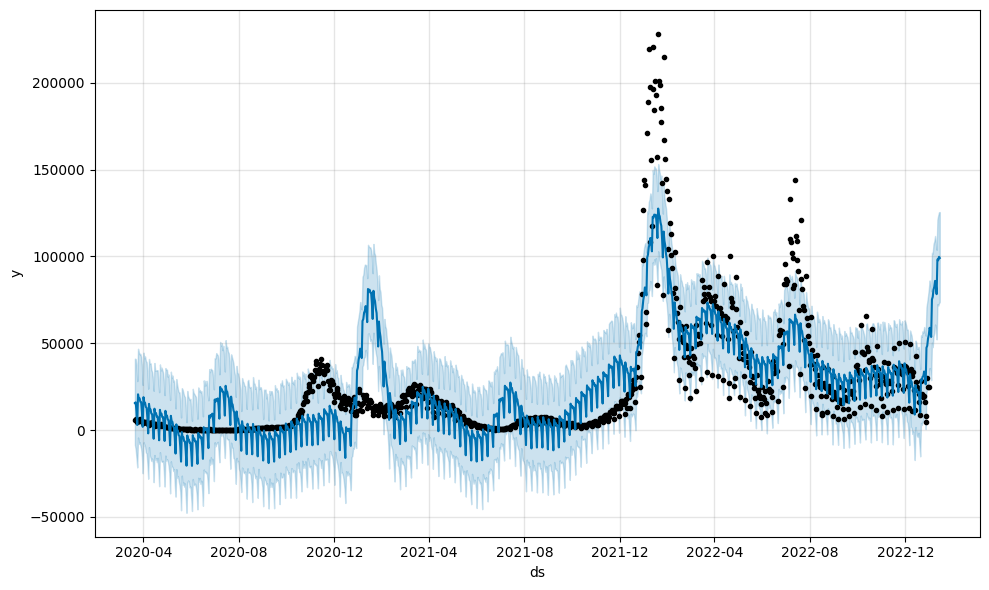

In [41]:
#dealing with outliers 
m = Prophet()
m.fit(train_italy)
future = m.make_future_dataframe(periods=14)
forecast = m.predict(future)
fig = m.plot(forecast)

The effect of the extreme outliers in 2021 reverberated into the future.I will set the outliers as NA since Prophet can handle missing values.

In [47]:
#set outliers to NA
Q1 = train_italy['y'].quantile(0.25)
Q3 = train_italy['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train_italy[(train_italy['y'] < lower_bound) | (train_italy['y'] > upper_bound)]

train_italy.loc[train_italy['y'] < lower_bound, 'y'] = None
train_italy.loc[train_italy['y'] > upper_bound, 'y'] = None

print(lower_bound)
print(upper_bound)

-38033.375
71999.625


In [48]:
train_italy['cap'] = 25000
test_italy['cap'] = 25000

## Model Development
### Model 1

13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing


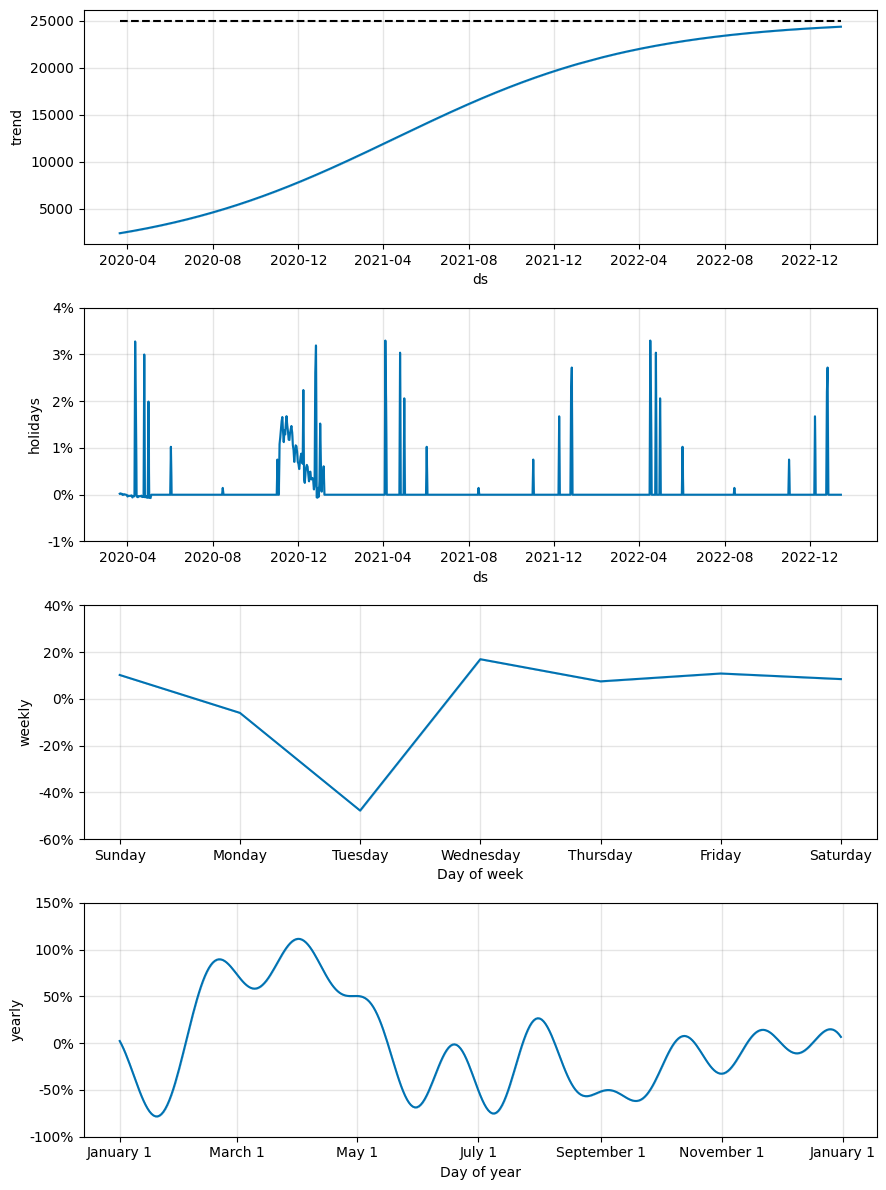

In [49]:
# holidays
m = Prophet(growth='logistic', 
            holidays = holiday_italy,
            seasonality_mode = 'multiplicative',
            holidays_prior_scale = 0.1,
            seasonality_prior_scale = 1,
            changepoint_prior_scale = 0.05)
m.fit(train_italy)
# visualize holidays and seasonality
future = m.make_future_dataframe(periods=14)
future['cap'] = 25000
forecast = m.predict(future)
fig = m.plot_components(forecast)

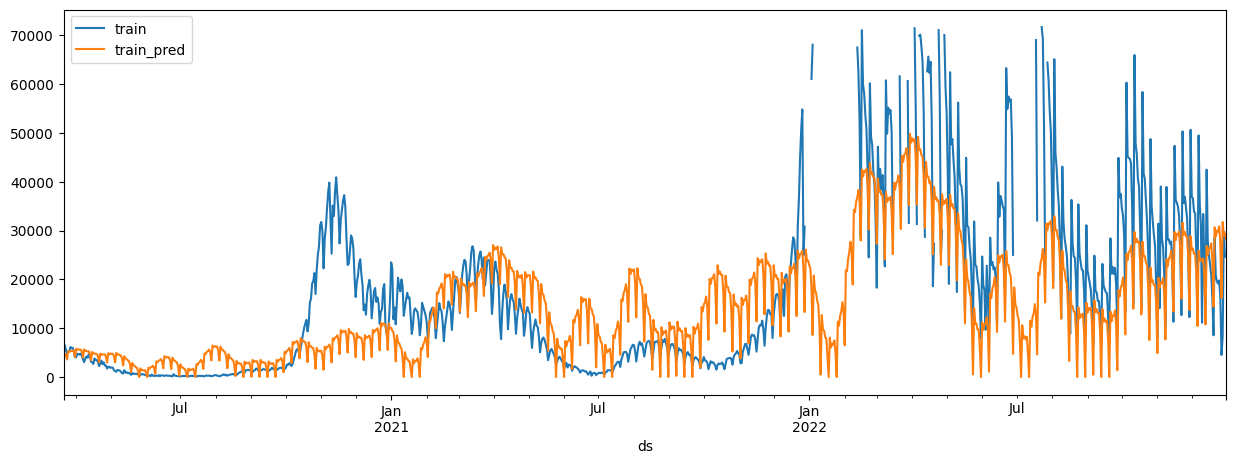

In [50]:
# base model with holiday
train_pred=m.predict(train_italy).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train_italy.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

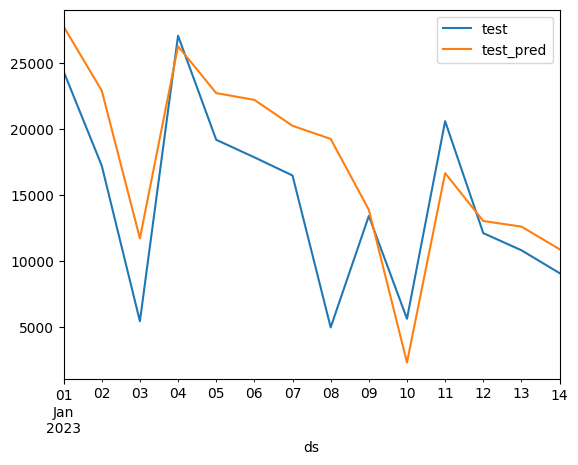

In [51]:
test_pred=m.predict(test_italy).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test_italy.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [53]:
test_rmse = np.sqrt(mean_squared_error(test_italy['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 5133.396639677636


## Cross Validation
https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important,on%20the%20corresponding%20testing%20set.


In [22]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

#Store the results
rmse = []
#Loop
for params in grid:
  #model
  m = Prophet(growth='logistic',
              holidays = holiday_italy,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.fit(train_italy)

  #CV
  df_cv = cross_validation(m,
                          horizon = '14 days',
                          period = '100 days',
                          initial = '365 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

12:57:02 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:03 - cmdstanpy - INFO 

KeyboardInterrupt: 

In [ ]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,29
changepoint_prior_scale,0.005
holidays_prior_scale,25
seasonality_mode,multiplicative
seasonality_prior_scale,5
rmse,10256.346519


In [340]:
m3 = Prophet(growth='logistic',
             holidays=holiday_italy,
             holidays_prior_scale = 25,
             seasonality_prior_scale = 5,
             changepoint_prior_scale = 0.005,
             seasonality_mode = 'multiplicative'
             )
m3.fit(train_italy)

16:40:45 - cmdstanpy - INFO - Chain [1] start processing
16:40:45 - cmdstanpy - INFO - Chain [1] done processing


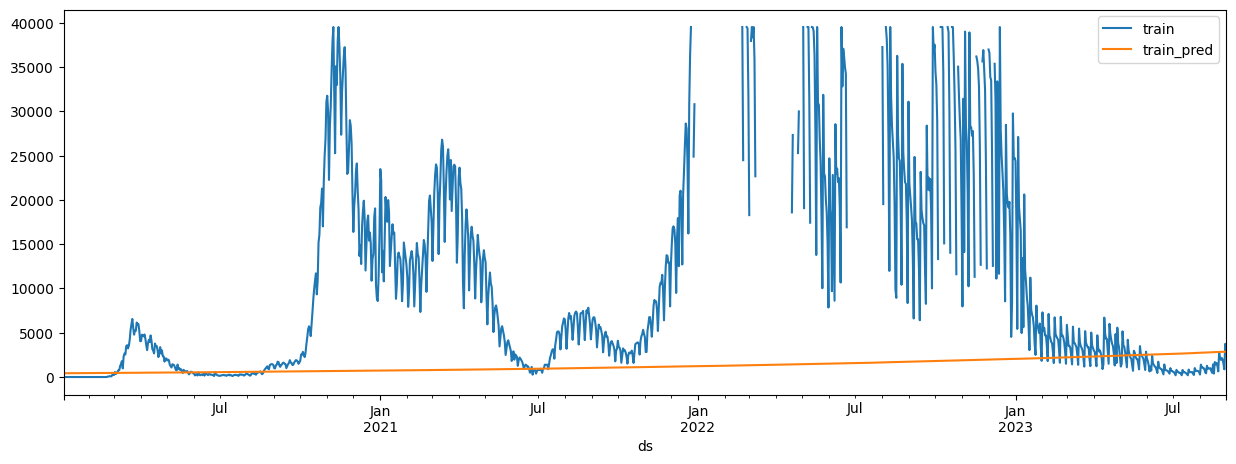

In [ ]:
train_pred=m3.predict(train_italy).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_pred[col] = train_pred[col].clip(lower=0.0)
pd.concat([train_italy.set_index('ds')['y'],train_pred['yhat']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

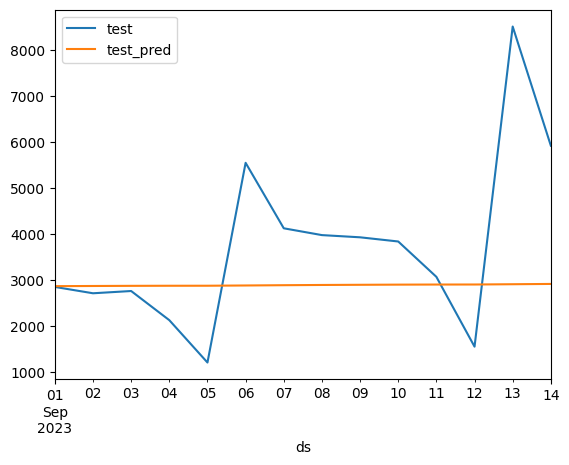

In [ ]:
test_pred=m3.predict(test_italy).set_index('ds')
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_pred[col] = test_pred[col].clip(lower=0.0)
pd.concat([test_italy.set_index('ds')['y'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [ ]:
test_rmse = np.sqrt(mean_squared_error(test['y'], test_pred['yhat']))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 1816.9250036904348
